# Towards Formally Describing Program Traces of Language Model Calls with Causal Influence Diagrams: A Sketch - Notebook Version
> Or, Causality for LangChain (in the future, probably), or Using Causal Influence Diagrams to explore Agent designs for Language Model Chaining

> By Brian Muhia

> CTO, Fahamu Inc

(or read this in Google Colab here: [Colab](https://colab.research.google.com/drive/1roLQgXhEtI83Q5vX1q24Q9iDgu5LFFWA#scrollTo=5b8fbbeb-e90b-4990-ac3e-d484205b78aa))

In [3]:
import pycid

/home/muhia/miniconda3/envs/fastai/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In this report, we analyze eleven agent designs implemented by an interface built within the factored cognition (or task decomposition, or process-based supervision) framework (https://primer.ought.org/), and use casual influence diagrams (CIDs) (Everitt et al, 2021) to formally describe the agent interactions, their influences and how they contribute towards performing a user query, based on context from a document archive.
This helps us in documenting the system while making plans for future changes, such as adding a reranking step, or adding verifiers that remove unwanted outputs or associations.

A research program on interface design is outlined, wherein we plan the use of mechanistic interpretability tooling to improve the causal influence diagrams by adding some weak notion of conditional probability distributions, and hypothesize their possible contribution towards formally modeling and representing the introduction of deceptive answers in a dataset of responses from agents involved in generating subquestions, filtering, answering sub-questions and aggregating context.


## Introduction
When we compose small, independent contributions from agents that know about the data they’re being asked about, we introduce a bias for representing the documents provided, which is counterbalanced by the bias from the models involved and how they have been trained, which may improve the answer quality by faithfully and factually representing the context, or they may entirely ignore relevant parts of the context and focus on others, or go off topic entirely.

We aim to illuminate this complex problem first by formally describing how the designs of two agent calls interact with context data and then by discussing how we might in the future analyze the dataset using a smaller local model with a causal tracing framework in order to visualize the factuality of agent responses with an animated CID. The specifics of this and analysis of the related data are left to future work.


## Related Work
The Causal Incentives working group (https://causalincentives.com/) has supported the release of the Python library PyCID (https://github.com/causalincentives/pycid), which we use to automate the visualisation process. 

## Process-Based Supervision
We aim to understand how systems designed through the task decomposition framework generate answers by observing and controlling data flow through the process by which answers are generated. We hope to learn more about how the specific type of answering process is working in practice by tracing chained calls to large language models and formalising the resulting program trace in a diagram that documents it. For this, we have several data points to build on, including:
+ User question
+ Answer
+ Data Source (list of paragraphs before filtering)
+ Context (list of paragraphs after classifying and filtering)
+ (Optional) Sub-questions & Sub-answers (Generated by sub-agents)
We aim to use data to study the causal relationships between each of these steps, as they are occurring at different times in the process of answering a user’s question, and thus influence each other in a directed acyclic graph.


1) Defintions

We begin this tutorial by defining a causal influence diagram (CID) and a causal influence model (CIM):
Definition: A Causal influence Diagram (CID) (Everitt et al, 2021) is a tuple (V,E) where:

    (V,E) is a directed acyclic graph with a set of vertices V connected by directed edges E⊆V×V.

    These vertices are partitioned into:

        D⊆V is a set of decision nodes represented by rectangles.

        U⊆V∖D is a set of utility nodes represented by diamonds and utility nodes have no successors.

        X=V∖(D∪U) is the set of chance nodes represented by ovals.


Definition: A Causal influence Model (CIM) (Everitt et al, 2021) is a tuple (V,E,θ) where (V,E) is a CID and:

    θ is a parameterisation over the nodes in the CID specifying:

        A finite domain dom(V) for each node V∈V.

        Real-valued domains dom(U)⊂R for all utility nodes U∈U.

        A set of conditional probability distributions (CPDs), Pr(V∣paV), for every chance and utility node X∪U∈V. Taken together, these form a partial distribution Pr(X,U:D)=∏V∈V∖DPr(V|PaV) over the variables in the CID.



In this report we only describe CIDs, leaving the automated program tracing and mechanistic interpretability work that would get us CIMs for future research.

<b>Examples showing eleven pycid CIDs.</b> These are manually written to describe two LLM chains that are currently being tested. The future hope is to use mechanistic interpretability first to introduce numerical weights and thus find a basis for representing CPDs with some weak notion of (positive or negative) contribution to the total factuality of the response. If there is merit to this, we aim to design a mechanism for automating the generation of these weakly factuality-weighted CIDs when provided with a program trace.

Notation:
+ Mn = Models/Agents are represented as decision nodes
+ C = Context. This is the set of agent instructions and related documents 
+ I = User Input (or Intent)
+ O = Output is a utility node


## Single Agent

This first call instantiates an agent M1 to answer a single user question, and a list of paragraphs C obtained after a separate search and filtering process as context, using it to answer the question as output O. We take the arrow to mean conditioning via prompting in this example.

In [101]:
cid  = pycid.CID(
    [
        ("C", "M1"),
        ("I", "C"),
        ("I", "M1"),
        ("M1", "O")
    ],
    decisions=["M1"],
    utilities=["O"]
)

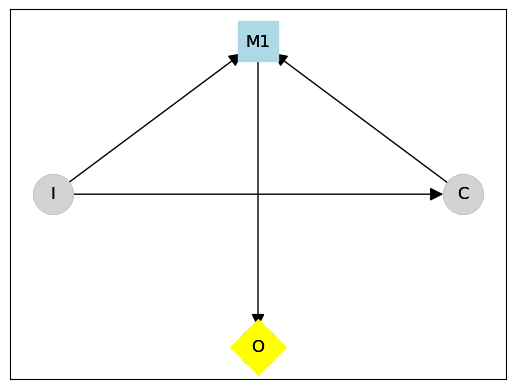

In [102]:
cid.draw()

Single interaction with the model M1. To explain this diagram, imagine the user I (for intent), typing a sentence in a search bar and pressing "Ask", which sends a message to a search process in the database to find documents that will get filtered for context C. The paragraphs that end up in C are there because of what the user asked. So the path (I, C) means "user asks a question and the search process finds paragraphs for context". If there is an arrow from the I node to a model Mn we say (I, Mn), which means the user’s intent is included in the model’s context. If there is no arrow from the I node to a model Mn, we say the user’s intent is omitted. The twin paths (I, M1) and (C, M1) mean "the user question and paragraphs are sent to the model". The path (M1, O) means "the model outputs its response and gets feedback".



## Multiple Agents
Here we explore the idea that it may be safer, or more robust in some cases to design an agent that can itself call more agents to help it gather more context, or verify its output.
### 2-Agent and 3-Agent Scenarios
We explore 3 simple cases that show the power of the CID formalism for explaining and understanding, in principle, the data flow and interactions we expect to happen in practice. We can think about what makes sense, and these can become a place to discuss any needed interventions before implementing complex architectures.
#### Sequential pair of agents
Agent M1 is instructed to ask one related question that can help answer the user's question/intent I. The second agent M2 takes agent M1's output and the context from the user search. Note the missing (I, M2). This means that the user’s intent would not be directly passed to the agent that actually answered them, so if an accidental inaccuracy was introduced by M1, or if M2 doesn’t fully take context C into account, it might be missing important context that would have been passed from (C, M2) or (M1, M2).

In [107]:
variant_8  = pycid.CID(
    [
        ("I", "C"),
        ("I", "M1"),
        ("C", "M1"),
        ("C", "M2"),
        ("M1", "M2"),
        ("M2", "O"),
    ],
    decisions=["M1", "M2"],
    utilities=["O"]
)

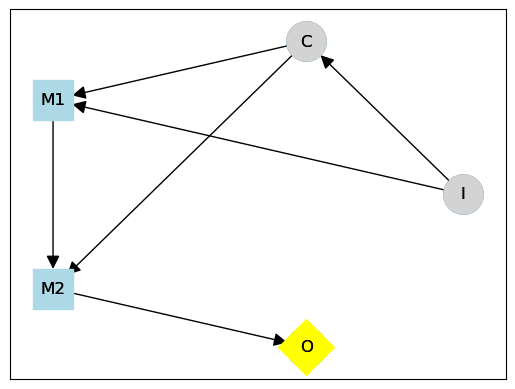

In [108]:
variant_8.draw()

We correct this in the next drawing by adding (I, M2). 

One purpose of this study is to explore intent alignment using some notation that helps us think about actual design decisions that could be made. Throughout the rest of the examples we will show variants of multi-agent designs where we omit the user’s intent from certain steps in the calls. Empirically, we do this by removing the user’s question from the sub-agent’s prompt. Think about (or empirically verify) what happens in the cases where we do this vs where it is maintained.


In [10]:
variant_8_correct  = pycid.CID(
    [
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("C", "M1"),
        ("C", "M2"),
        ("M1", "M2"),
        ("M2", "O"),
    ],
    decisions=["M1", "M2"],
    utilities=["O"]
)

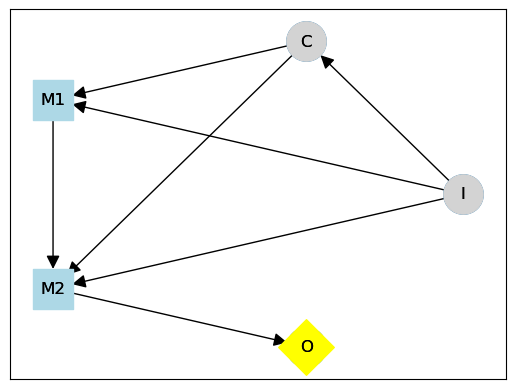

In [11]:
variant_8_correct.draw()

When the graph is correct we see how the user’s intent is present in every step of the call chain, which increases the likelihood that it is satisfied, even if each agent M1 and M2 is equally unreliable. However any unreliability in M1 would be amplified by its output being piped to M2. 
#### Parallel 2- and 3-agent designs.
We want to think about parallel agents as well, primarily due to latency.


In [12]:
variant_9  = pycid.CID(
    [
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("C", "M1"),
        ("C", "M2"),
        ("M1", "O"),
        ("M2", "O"),
    ],
    decisions=["M1", "M2"],
    utilities=["O"]
)

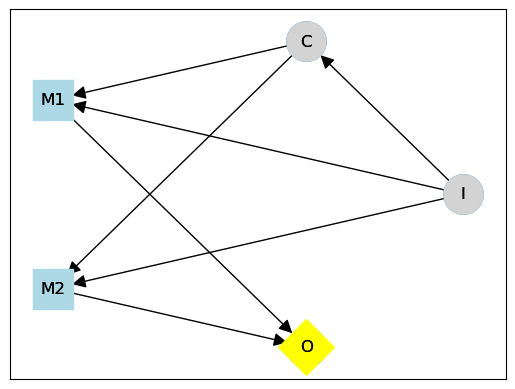

In [13]:
variant_9.draw()

This seems like the safety mechanism that Tesla vehicles use. Two models that output their action to a controller outside the system, from the observations in C and the driver’s intent I (the route). This breaks down a bit because if both M1 and M2 are wrong, we would have two wrong answers. That seems much worse. Also, for interface reasons we wouldn't want output from two models stored in a data store and shown to the user, we instead want output from one model that aggregates, modifies or otherwise filters M1 and M2's responses. Here's the parallel example updated to add a third agent to aggregate the output from parallel agents. 

In [14]:
variant_10  = pycid.CID(
    [
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("C", "M1"),
        ("C", "M2"),
        ("M1", "M3"),
        ("M2", "M3"),
        ("C", "M3"),
        ("M3", "O"),
    ],
    decisions=["M1", "M2", "M3"],
    utilities=["O"]
)

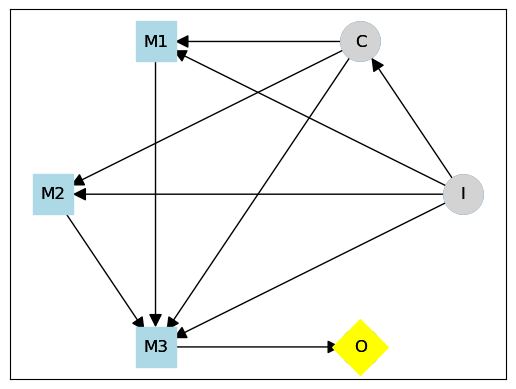

In [15]:
variant_10.draw()

It’s a bit unusual to look for parallel steps and find 3, instead of 2 agents that do the right thing. Maybe it’s a rule. Maybe if you want parallel steps, you don't want two agents, you want three agents. Also, parallel agents involve at least two “sequential steps”. In terms of information flow, there are two parallel paths from C to M3, through M1 and M2 at once. Note how, by counting the incoming arrows, both models M1 and M2 have two sources of information, while M3 has four. Claim: the more agents there are in the population, the more pressure there will be on at least one of them to get it right. 

To start thinking about how this might help with alignment, which is relevant for the more complex cases, we can show a variant of this which omits the user’s intent from the parallel steps M1 and M2. In this case, they get no user input and are just asked to do something with the context C.Claim: if both M1 and M2 get it wrong or can’t generalise and make something up, M3’s output will fail to satisfy user intent.

In [16]:
variant_10_omit  = pycid.CID(
    [
        ("I", "C"),
        ("I", "M3"),
        ("C", "M1"),
        ("C", "M2"),
        ("M1", "M3"),
        ("M2", "M3"),
        ("C", "M3"),
        ("M3", "O"),
    ],
    decisions=["M1", "M2", "M3"],
    utilities=["O"]
)

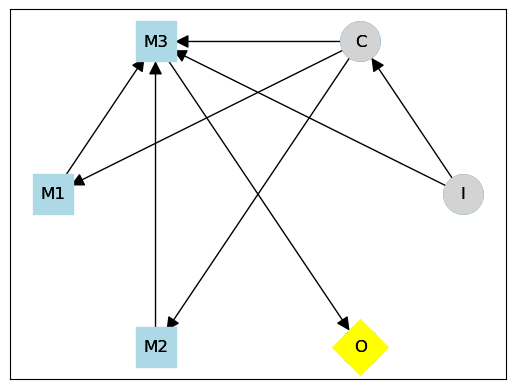

In [17]:
variant_10_omit.draw()

And a variant where we turn the variant_10 into a sequential model in testing for use in a chain that includes two steps of verification. (see the screengrab below the diagram, grabbed from Esben Kran's presentation at the Alignment Jam #8: https://youtu.be/XauqlTQm-o4?t=717)

In [29]:
variant_10_sequential  = pycid.CID(
    [
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("C", "M1"),
        ("C", "M2"),
        ("M1", "M2"),
        ("M2", "M3"),
        ("C", "M3"),
        ("M3", "O"),
    ],
    decisions=["M1", "M2", "M3"],
    utilities=["O"]
)

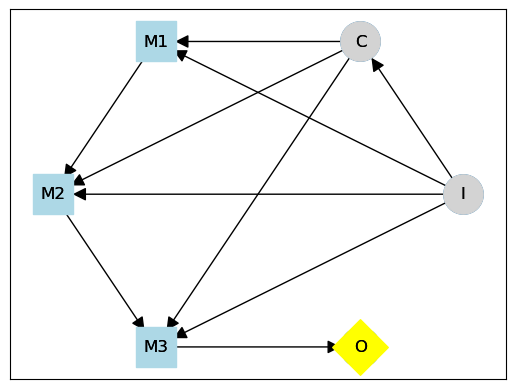

In [30]:
variant_10_sequential.draw()

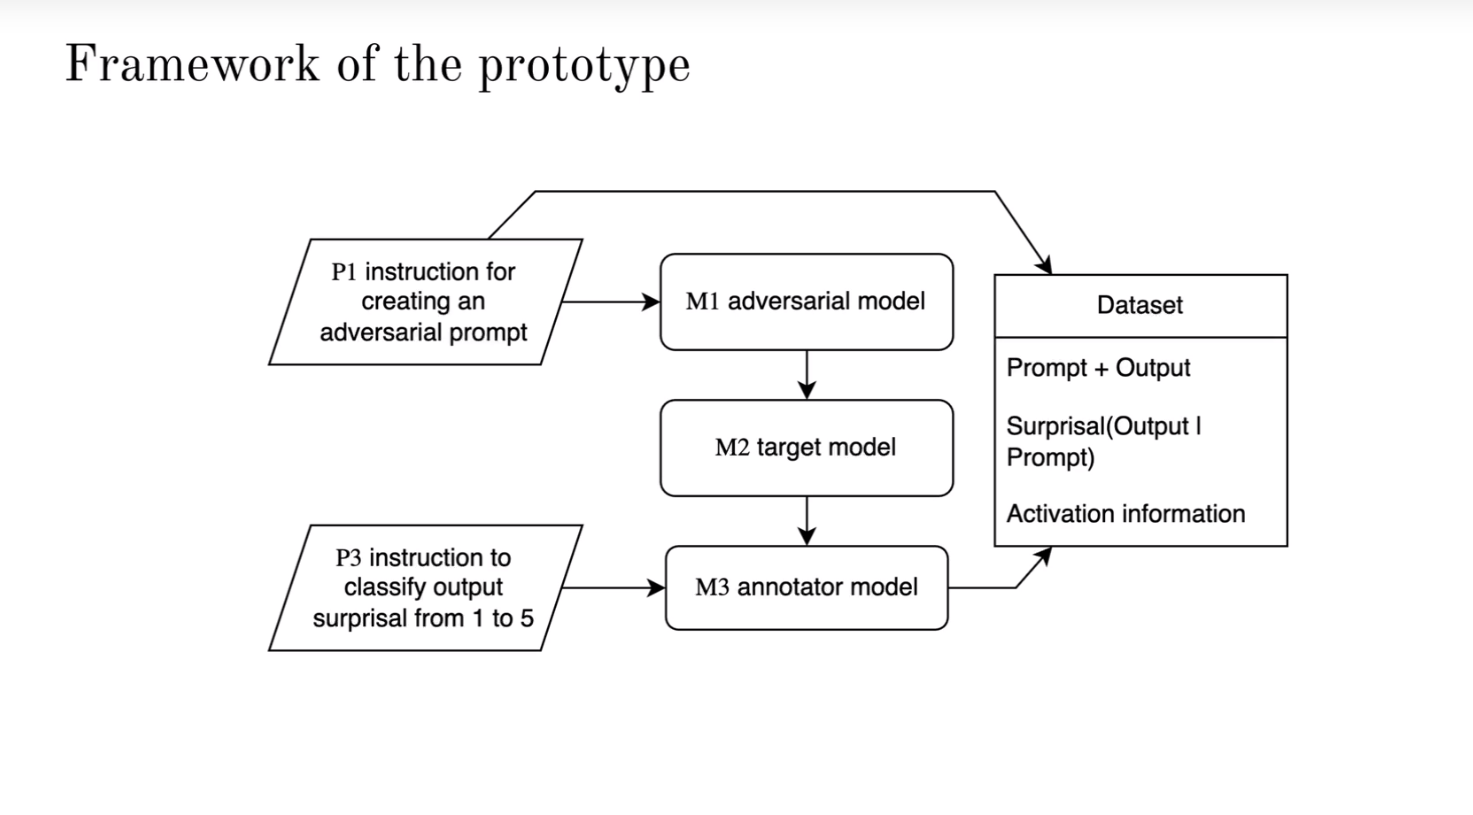

In [34]:
from PIL import Image
Image.open('./fuzzing.png')

Next, we show a variant which adds a ranking step RANK, as a new decision node, to re-rank or filter answers from M1 and M2, while maintaining user intent at all steps.

In [26]:
variant_10_rank  = pycid.CID(
    [
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("C", "M1"),
        ("C", "M2"),
        ("C", "RANK"),
        ("I", "RANK"),
        ("M1", "RANK"),
        ("M2", "RANK"),
        ("RANK", "M3"),
        ("C", "M3"),
        ("M3", "O"),
    ],
    decisions=["M1", "M2", "M3", "RANK"],
    utilities=["O"]
)

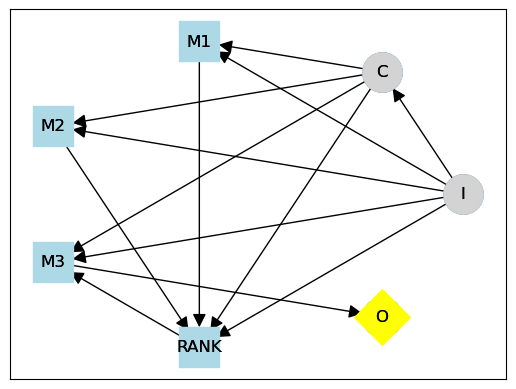

In [27]:
variant_10_rank.draw()

However, we might imagine a scenario where this variant is vulnerable to adversarial input, would we want the ranker to be blind to user input? An alternative to this might be ranking without user input somehow, then we would have to decide which distribution RANK was built from. Two cases to consider here might be when the distribution matches the distribution of data from which C is drawn, by the search process that the intent I invokes in the path (I, C). That way, the ranking process could perform such that it could downrank everything if necessary, forcing the context C to be at the top of the rank, ensuring the user always gets an abstracted version of the context in the case of untrusted input. Here then is this variant where RANK is blind to user input. Whether it is better depends overall on what the system designer intends to accomplish.

In [32]:
variant_10_rank_intent_blind  = pycid.CID(
    [
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("C", "M1"),
        ("C", "M2"),
        ("C", "RANK"),
        ("M1", "RANK"),
        ("M2", "RANK"),
        ("RANK", "M3"),
        ("C", "M3"),
        ("M3", "O"),
    ],
    decisions=["M1", "M2", "M3", "RANK"],
    utilities=["O"]
)

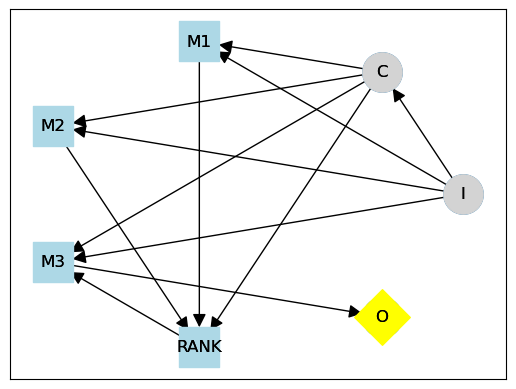

In [33]:
variant_10_rank_non_adv.draw()

In [24]:
variant_10_rank_sequential  = pycid.CID(
    [
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("C", "M1"),
        ("C", "M2"),
        ("I", "RANK"),
        ("M1", "RANK"),
        ("M2", "RANK"),
        ("M1", "M2"),
        ("M2", "M3"),
        ("RANK", "M3"),
        ("C", "M3"),
        ("M3", "O"),
    ],
    decisions=["M1", "M2", "M3", "RANK"],
    utilities=["O"]
)

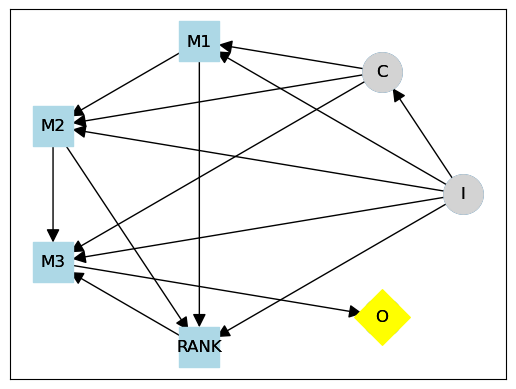

In [25]:
variant_10_rank_sequential.draw()

What follows are a few somewhat more complex scenarios, and more discussion of the safety relevance of this work.
#### 7-Agent Parallel Scenarios
The second set first instantiates a single agent M1 to generate 2-5 sub-questions based on user input I and the document context C. This instantiates 5 parallel sub-agents (M2-M6) to answer each of these sub-questions using the context, and a 7th agent M7 to aggregate the sub-answers and context into a more detailed answer as output O.
##### (PV1) Parallel Variant 1 where the user's intent is omitted from the context of agents M2-M6.


In [83]:
variant_1  = pycid.CID(
    [
        ("C", "M1"),
        ("C", "M2"),
        ("C", "M3"),
        ("C", "M4"),
        ("C", "M5"),
        ("C", "M6"),
        ("C", "M7"),
        ("I", "C"),
        ("I", "M1"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M1", "M6"),
        ("M2", "M7"),
        ("M3", "M7"),
        ("M4", "M7"),
        ("M5", "M7"),
        ("M6", "M7"),
        ("M7", "O"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7"],
    utilities=["O"]
)

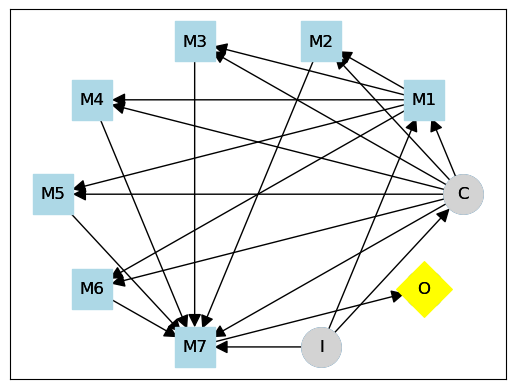

In [84]:
variant_1.draw()

My current hypothesis is that there are millions of these diagrams and also that there are easy ways to see possible failure modes in the designs of factored cognition schemes before they are implemented.

(PV2) Parallel Variant 2 where the user's question is included in the context of all sub-agents.

In [85]:
variant_2  = pycid.CID(
    [
        ("C", "M1"),
        ("C", "M2"),
        ("C", "M3"),
        ("C", "M4"),
        ("C", "M5"),
        ("C", "M6"),
        ("C", "M7"),
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("I", "M4"),
        ("I", "M5"),
        ("I", "M6"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M1", "M6"),
        ("M2", "M7"),
        ("M3", "M7"),
        ("M4", "M7"),
        ("M5", "M7"),
        ("M6", "M7"),
        ("M7", "O"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7"],
    utilities=["O"]
)

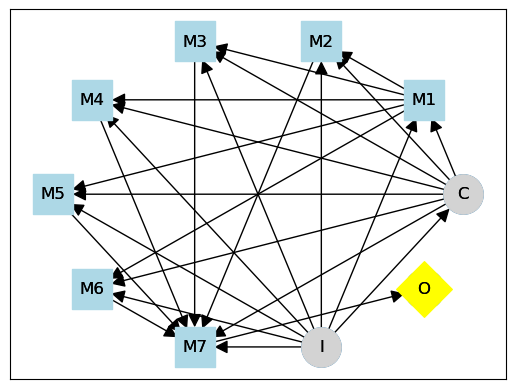

In [86]:
variant_2.draw()

#### 7-Agent Sequential Scenarios
We clean up the two above variants to prevent data duplication in the M7 prompt, and add a few more links to describe 2 more variants (SV1 and SV2) that explore the idea of chaining in a more sequential way, where data flows directly from Mn to Mn+1. So whatever M1 starts to do, it may be amplified, verified, filtered out or somehow modified many times by the time M7 encounters it. This all depends on the design of data flow. We use this formalism to note that as decision nodes with some level of independence and unreliability, factuality might be broken at any stage and we would want to detect it.

By intuition, my prediction is that in sequential scenarios errors would compound in subtle ways to more sub-agents faster than in parallel scenarios.

There are still more opportunities for either early stopping or self-healing in the sequential case since assuming the detection of a lack of factual grounding in e.g. node M3 in the two Sequential variants, means that we may have an opportunity to remove that sub-answer and retry, or remove that node entirely by blanking out the text. <b>Qn:</b> So what would be a good way to deal with factuality issues in Parallel Agents M2-M6?


(SV1) Variant 3 where the input is included in all agents M1-M7, but has an issue with data duplication/copying in the prompt. How would you fix it? (Answer below)
It has a second error, in that the path (I, C) is missing.

In [91]:
variant_3_dupes  = pycid.CID(
    [
        ("C", "M1"),
        ("C", "M2"),
        ("C", "M3"),
        ("C", "M4"),
        ("C", "M5"),
        ("C", "M6"),
        ("C", "M7"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("I", "M4"),
        ("I", "M5"),
        ("I", "M6"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M1", "M6"),
        ("M2", "M3"),
        ("M2", "M7"),
        ("M3", "M4"),
        ("M3", "M7"),
        ("M4", "M5"),
        ("M4", "M7"),
        ("M5", "M6"),
        ("M5", "M7"),
        ("M6", "M7"),
        ("M7", "O"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7"],
    utilities=["O"]
)

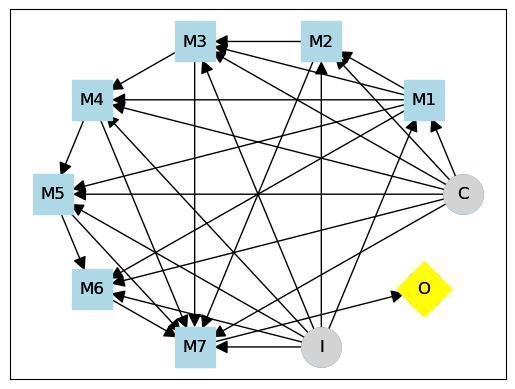

In [92]:
variant_3_dupes.draw()

Answer (don't peek!):

(SV1) Variant 3 with the data duplication error fixed

In [22]:
variant_6  = pycid.CID(
    [
        ("C", "M1"),
        ("C", "M2"),
        ("C", "M3"),
        ("C", "M4"),
        ("C", "M5"),
        ("C", "M6"),
        ("C", "M7"),
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("I", "M4"),
        ("I", "M5"),
        ("I", "M6"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M5", "M6"),
        ("M1", "M6"),
        ("M2", "M3"),
        ("M3", "M4"),
        ("M4", "M5"),
        ("M5", "M6"),
        ("M6", "M7"),
        ("M7", "O"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7"],
    utilities=["O"]
)

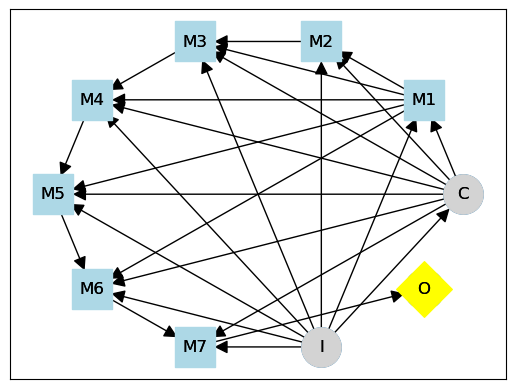

In [23]:
variant_6.draw()

In [97]:
variant_4  = pycid.CID(
    [
        ("C", "M1"),
        ("C", "M2"),
        ("C", "M3"),
        ("C", "M4"),
        ("C", "M5"),
        ("C", "M6"),
        ("C", "M7"),
        ("I", "C"),
        ("I", "M1"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M1", "M6"),
        ("M5", "M6"),
        ("M2", "M3"),
        ("M3", "M4"),
        ("M4", "M5"),
        ("M5", "M6"),
        ("M6", "M7"),
        ("M7", "O"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7"],
    utilities=["O"]
)

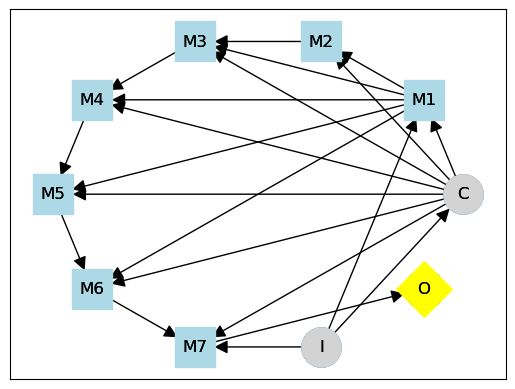

In [98]:
variant_4.draw()

In [99]:
variant_6  = pycid.CID(
    [
        ("C", "M1"),
        ("C", "M2"),
        ("C", "M3"),
        ("C", "M4"),
        ("C", "M5"),
        ("C", "M6"),
        ("C", "M7"),
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("I", "M4"),
        ("I", "M5"),
        ("I", "M6"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M5", "M6"),
        ("M1", "M6"),
        ("M2", "M3"),
        ("M3", "M4"),
        ("M4", "M5"),
        ("M5", "M6"),
        ("M6", "M7"),
        ("M7", "O"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7"],
    utilities=["O"]
)

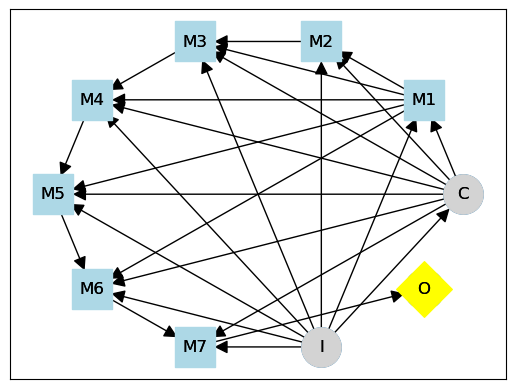

In [100]:
variant_6.draw()

### Exercises
1. How would one filter the data flow to M7 and prevent deceptive answers from the previous agents from causing M7 to deceive the user, assuming each agent is equally unreliable. 
2. Which of PV1 vs PV2 or SV1 vs SV2 are more aligned with the user’s intent? 
3. When you consider all of them, together? 
4. Could we rank them in order of “alignment to user intent”? 
5. Which would be more likely to cause an accident? 
6. Could we tell just from analysing the drawing, i.e. before implementing them?

<b>Hint</b>: Count the arrows coming from the I nodes. Again, If there is an arrow from e.g. (I, M4), we say the user’s intent is included in M4’s context. We might assume that M7 gets the same information in both (Sequential and Parallel) cases of Variant 1, but that variant either benefits, or fails creatively or catastrophically, from a slightly more independent search for answers that may or may not be faithful to the context, given its instructions and the sub-questions generated by M1.


### Relationship to ML Safety
1. If we zoom in on one problem, like accidental inaccuracy, we can try to think about which group of architectures propagates errors faster, and which intervention would fix these issues. For example, a decision to include a re-ranker or filtering model would be demonstrated in one of these drawings, and a discussion could be had about data flow, and at which point. Preventing errors from accumulating until they reach M7 would be a strong priority.
2. We consider the “prompt”, or any incoming arrow in the diagrams, to be the goal. If SV2 was a hierarchical planner, it would create approval-guided sub-agents, whereas SV1 would not. We can tell if we only consider the goals, rather than the behaviour of the agents. SV1 sub-agents could experience a drift in their goals and misrepresent what the user asked for. We would therefore not get the benefits of approval-guided action, or search, for those steps of the overall system’s operation.
3. Assuming a system that is given a lot of power over its environment is coordinated in this way, we would want to characterise coordination failures from agents that are assumed to be equal to one another but each have the same failure mode that can compound across agents. A coordination failure in SV1 might get much worse very quickly when left unchecked. The strategy of intervening on the data flow in each step to create an illusion of safety breaks down when the pillars themselves are unstable.
4. Formalising the ways in which multi-agent systems interact with their users is a purpose of the causal incentives program. My aim in this is to add more links between the two dense subgraphs of mechanistic interpretability and causal incentives.
5. Understanding the ways each multi-agent interaction intersects with questions related to introduced unfairness/bias/lack of generalizability through training methods and dataset imbalance.
6. In cases when we want to use human feedback to improve answer quality, the design of the structure of the reward modeling scheme is something people have to think very carefully about. Designing RLHF reward schemes is a complex problem primarily due to the problem of over optimization and reward hacking. Maybe we can illuminate this problem by using contributions to total factuality to explore different reward mechanisms that use this information.
7. Representing debates as mechanised causal games would probably help us develop another level of analysis over debate scenarios.
Variant 7 - Each agent is free to search for (and filter the validity of) extra context in order to augment the generation of the next answer.

Thanks to Ryan Carey for useful comments and suggestions.
### References
1. [Causal Incentives Working Group] https://causalincentives.com
2. PyCID: A Python Library for Causal Influence Diagrams https://conference.scipy.org/proceedings/scipy2021/pdfs/james_fox.pdf
3. Agent Incentives: A Causal Perspective https://arxiv.org/pdf/2102.01685.pdf
4. Modeling AGI Safety Frameworks with Causal Influence Diagrams https://arxiv.org/pdf/1906.08663.pdf
5. Understanding Agent Incentives using Causal Influence Diagrams, Part 1: Single Action Settings https://arxiv.org/abs/1902.09980
6. Locating and Editing Factual Associations in GPT https://rome.baulab.info/


More examples? Submit a pull request!

Variant where all sub-agents have their own context to pull from and that gives the system reward for sharing the entire collected subagent context.

In [37]:
variant_7_context_reward  = pycid.CID(
    [
        ("C1", "M1"),
        ("C1", "M2"),
        ("C1", "M3"),
        ("C1", "M4"),
        ("C1", "M5"),
        ("C1", "M6"),
        ("C1", "M7"),
        ("C1", "M2"),
        ("C2", "M3"),
        ("C3", "M4"),
        ("C4", "M5"),
        ("C5", "M6"),
        ("C6", "M7"),
        ("C1", "O"),
        ("C2", "O"),
        ("C3", "O"),
        ("C4", "O"),
        ("C5", "O"),
        ("C6", "O"),
        ("I", "C1"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("I", "M4"),
        ("I", "M5"),
        ("I", "M6"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M1", "M6"),
        ("M5", "M6"),
        ("M2", "M3"),
        ("M3", "M4"),
        ("M4", "M5"),
        ("M5", "M6"),
        ("M6", "M7"),
        ("M7", "O"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7"],
    utilities=["O"]
)

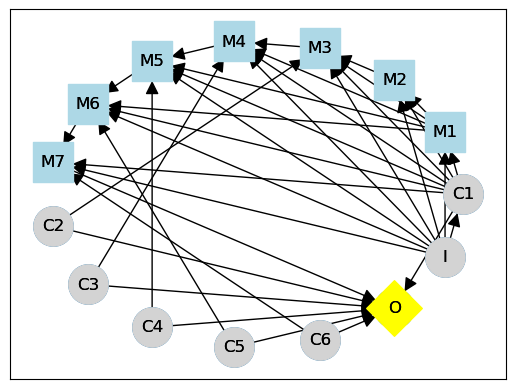

In [38]:
variant_7_context_reward.draw()

The above model might overload the user with information, so next we design a variant that ranks all context plus model M7's response, based on user input before outputting to the world.

In [47]:
variant_7_context_ranking  = pycid.CID(
    [
        ("C1", "M1"),
        ("C1", "M2"),
        ("C1", "M3"),
        ("C1", "M4"),
        ("C1", "M5"),
        ("C1", "M6"),
        ("C1", "M7"),
        ("C1", "M2"),
        ("C2", "M3"),
        ("C3", "M4"),
        ("C4", "M5"),
        ("C5", "M6"),
        ("C6", "M7"),
        ("I", "RANK"),
        ("C1", "RANK"),
        ("C2", "RANK"),
        ("C3", "RANK"),
        ("C4", "RANK"),
        ("C5", "RANK"),
        ("C6", "RANK"),
        ("RANK", "O"),
        ("I", "C1"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("I", "M4"),
        ("I", "M5"),
        ("I", "M6"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M1", "M6"),
        ("M5", "M6"),
        ("M2", "M3"),
        ("M3", "M4"),
        ("M4", "M5"),
        ("M5", "M6"),
        ("M6", "M7"),
        ("M7", "RANK"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7", "RANK"],
    utilities=["O"]
)

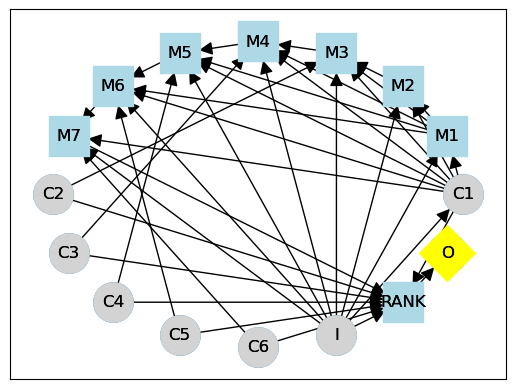

In [48]:
variant_7_context_ranking.draw()

In [103]:
variant_7  = pycid.CID(
    [
        ("C1", "M1"),
        ("C1", "M2"),
        ("C1", "M3"),
        ("C1", "M4"),
        ("C1", "M5"),
        ("C1", "M6"),
        ("C1", "M7"),
        ("C1", "M2"),
        ("C2", "M3"),
        ("C3", "M4"),
        ("C4", "M5"),
        ("C5", "M6"),
        ("C6", "M7"),
        ("I", "C1"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("I", "M4"),
        ("I", "M5"),
        ("I", "M6"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M1", "M6"),
        ("M5", "M6"),
        ("M2", "M3"),
        ("M3", "M4"),
        ("M4", "M5"),
        ("M5", "M6"),
        ("M6", "M7"),
        ("M7", "O"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7"],
    utilities=["O"]
)

In [ ]:
variant_2_context_ranking  = pycid.CID(
    [
        ("C", "M1"),
        ("C", "M2"),
        ("C", "M3"),
        ("C", "M4"),
        ("C", "M5"),
        ("C", "M6"),
        ("C", "M7"),
        ("I", "C"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("I", "M4"),
        ("I", "M5"),
        ("I", "M6"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M1", "M6"),
        ("M2", "M7"),
        ("M3", "M7"),
        ("M4", "M7"),
        ("M5", "M7"),
        ("M6", "M7"),
        ("M7", "O"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7"],
    utilities=["O"]
)

In [ ]:
parallel_variant_7_context_ranking  = pycid.CID(
    [
        ("C1", "M1"),
        ("C1", "M2"),
        ("C1", "M3"),
        ("C1", "M4"),
        ("C1", "M5"),
        ("C1", "M6"),
        ("C1", "M7"),
        ("C1", "M2"),
        ("C2", "M3"),
        ("C3", "M4"),
        ("C4", "M5"),
        ("C5", "M6"),
        ("C6", "M7"),
        ("I", "RANK"),
        ("C1", "RANK"),
        ("C2", "RANK"),
        ("C3", "RANK"),
        ("C4", "RANK"),
        ("C5", "RANK"),
        ("C6", "RANK"),
        ("RANK", "O"),
        ("I", "C1"),
        ("I", "M1"),
        ("I", "M2"),
        ("I", "M3"),
        ("I", "M4"),
        ("I", "M5"),
        ("I", "M6"),
        ("I", "M7"),
        ("M1", "M2"),
        ("M1", "M3"),
        ("M1", "M4"),
        ("M1", "M5"),
        ("M1", "M6"),
        ("M5", "M6"),
        ("M2", "M3"),
        ("M3", "M4"),
        ("M4", "M5"),
        ("M5", "M6"),
        ("M6", "M7"),
        ("M7", "RANK"),
    ],
    decisions=["M1", "M2", "M3", "M4", "M5", "M6", "M7", "RANK"],
    utilities=["O"]
)

Variant 8 - sequential pair of agents. Agent M1 is instructed to ask a related question that can help answer the user's question I. The second agent M2 takes agent M1's output and the context from the user search, .

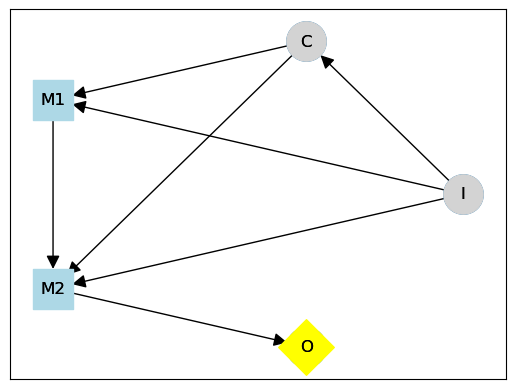

In [123]:
variant_8_correct.draw()

We want to think about parallel agents as well, primarily due to latency.

Variant 9 - Pair of parallel agents.

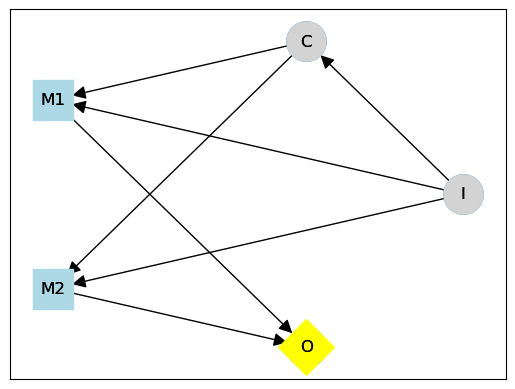

In [125]:
variant_9.draw()

This case breaks down a bit here because for interface reasons we wouldn't want output from two models stored in a data store and shown to the user, we instead want output from one model that aggregates, modifies or otherwise filters M1 and M2's responses. If both M1 and M2 are wrong, we have two wrong answers. That seems much worse.

Here's variant 9 updated to add a third agent to aggregate the output from parallel agents. This seems like a rule. If you want parallel agents, you don't want 2 agents, you want 3 agents. Also, parallel agents involve at least two sequential steps.

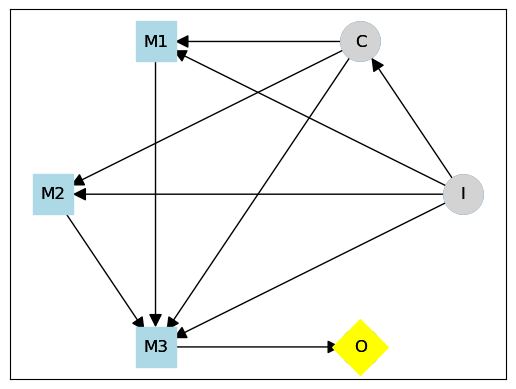

In [119]:
variant_10.draw()

Variant with a ranking step after M1 and M2

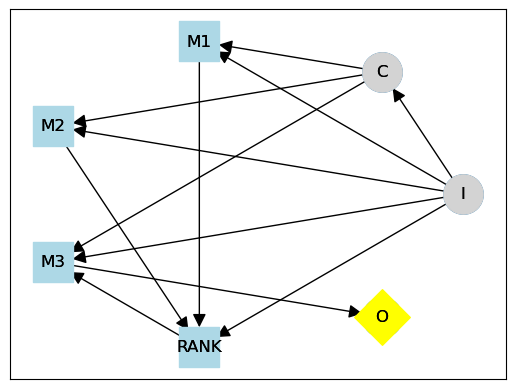

In [137]:
variant_10_rank.draw()

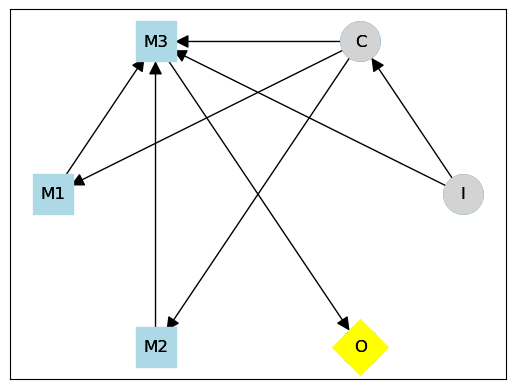

In [135]:
variant_10_omit.draw()